In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.interpolate import griddata
from scipy.special import erf
from scipy.odr import ODR, Model, RealData

from astropy.coordinates import SkyCoord
import astropy.units as u

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import Normalize

import getdist
from getdist import plots, MCSamples

from loess.loess_2d import loess_2d

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
if not ROOT_PATH in sys.path: sys.path.append(ROOT_PATH)
from main_code.utils.constants import *
from main_code.utils.functions import *
from main_code.utils.CosmoFunc import *
from main_code.utils.filepaths import *

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# Not multiplying by `res_var`

In [133]:
def ODR_linear_fit(x, y, xerr=None, yerr=None, m_guess=1.0, b_guess=0.0, left_boundary=None, right_boundary=None):
    """Helper function to fit a line with errors in both x and y axes.

    Args:
        x (): x data
        y (_type_): y data
        xerr (_type_, optional): error in x. Defaults to None.
        yerr (_type_, optional): error in y. Defaults to None.
        m_guess (float, optional): initial guess for the slope. Defaults to 1.0.
        b_guess (float, optional): initial guess for the intercept. Defaults to 0.0.
        left_boundary (_type_, optional): starting point for prediction line. Defaults to None.
        right_boundary (_type_, optional): ending point for prediction line. Defaults to None.
    """
    def f(B, x):
        '''Linear function y = m*x + b'''
        # B is a vector of the parameters.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        #
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]
    
    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    odr = ODR(mydata, linear, beta0=[m_guess, b_guess])
    odr_output = odr.run() 
    m_pred, b_pred = odr_output.beta
    m_err, b_err = np.sqrt(np.diag(odr_output.cov_beta))
    print(f"Slope: {m_pred} ± {m_err} | Intercept: {b_pred} ± {b_err}")

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(odr_output.beta, odr_output.cov_beta, n_trial).T

    # Plot boundaries
    left_ = x.min()
    right_ = x.max()

    if left_boundary:
        left_ = left_boundary
    if right_boundary:
        right_ = right_boundary

    x_pred = np.linspace(left_, right_, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_pred + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_pred + b_pred
    y_pred_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_pred_upper = np.quantile(y_trial, q=0.84, axis=0)

    return odr_output, x_pred, y_pred, y_pred_lower, y_pred_upper

Slope: 0.9864866791691459 ± 0.20811172911475942 | Intercept: 0.018785081774359634 ± 0.17807017827048455
Slope error from sd_beta =  0.03764484937710837


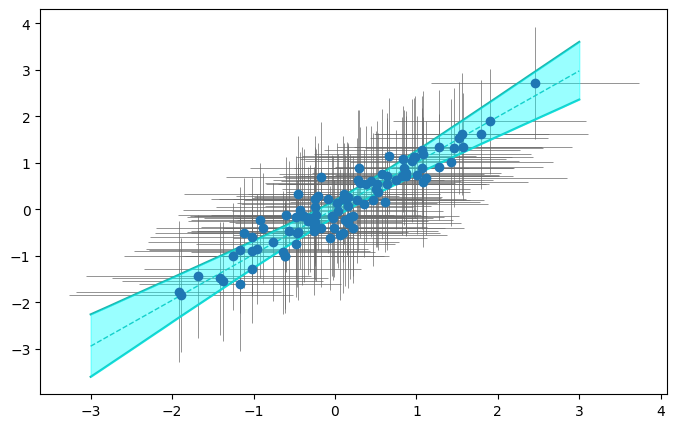

In [134]:
np.random.seed(42)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create fake data
N_data = 100
mean = [0, 0]
cov_mat = np.array([
        [1, 0.95],
        [0.95, 1]
    ])
err_scatter = 0.25

data = np.random.multivariate_normal(
    mean=mean,
    cov=cov_mat,
    size=N_data
)

x = data[:, 0]
y = data[:, 1]
xerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data)) * 5
yerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data)) * 5
ax.errorbar(x, y, yerr, xerr, fmt='o', elinewidth=0.5, ecolor='dimgrey')

# ODR fits
res, x_pred, y_pred, y_pred_lower, y_pred_upper = ODR_linear_fit(x, y, xerr, yerr, left_boundary=-3, right_boundary=3)
print("Slope error from sd_beta = ", res.sd_beta[0])

ax.plot(x_pred, y_pred, c='lightseagreen', ls="--", lw=1.0, zorder=2)
ax.plot(x_pred, y_pred_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_pred, y_pred_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_pred, y1=y_pred_lower, y2=y_pred_upper, color='cyan', alpha=0.4, zorder=2)

Result: multiplying the errors change the confidence interval.

# Multiplying by `res_var`

In [93]:
def ODR_linear_fit(x, y, xerr=None, yerr=None, m_guess=1.0, b_guess=0.0, left_boundary=None, right_boundary=None):
    """Helper function to fit a line with errors in both x and y axes.

    Args:
        x (): x data
        y (_type_): y data
        xerr (_type_, optional): error in x. Defaults to None.
        yerr (_type_, optional): error in y. Defaults to None.
        m_guess (float, optional): initial guess for the slope. Defaults to 1.0.
        b_guess (float, optional): initial guess for the intercept. Defaults to 0.0.
        left_boundary (_type_, optional): starting point for prediction line. Defaults to None.
        right_boundary (_type_, optional): ending point for prediction line. Defaults to None.
    """
    def f(B, x):
        '''Linear function y = m*x + b'''
        # B is a vector of the parameters.
        # x is an array of the current x values.
        # x is in the same format as the x passed to Data or RealData.
        #
        # Return an array in the same format as y passed to Data or RealData.
        return B[0]*x + B[1]
    
    # ODR stuff
    linear = Model(f)
    mydata = RealData(x=x, y=y, sx=xerr, sy=yerr)
    odr = ODR(mydata, linear, beta0=[m_guess, b_guess])
    odr_output = odr.run() 
    m_pred, b_pred = odr_output.beta
    m_err, b_err = np.sqrt(np.diag(odr_output.cov_beta * odr_output.res_var))
    print(f"Slope: {m_pred} ± {m_err} | Intercept: {b_pred} ± {b_err}")

    # Create MC sample
    n_trial = 10000
    m_trial, b_trial = np.random.multivariate_normal(odr_output.beta, odr_output.cov_beta * odr_output.res_var, n_trial).T

    # Plot boundaries
    left_ = x.min()
    right_ = x.max()

    if left_boundary:
        left_ = left_boundary
    if right_boundary:
        right_ = right_boundary

    x_pred = np.linspace(left_, right_, 1000)
    y_trial = m_trial.reshape(-1, 1) * x_pred + b_trial.reshape(-1, 1)
    y_pred = m_pred * x_pred + b_pred
    y_pred_lower = np.quantile(y_trial, q=0.16, axis=0)
    y_pred_upper = np.quantile(y_trial, q=0.84, axis=0)

    return odr_output, x_pred, y_pred, y_pred_lower, y_pred_upper

Slope: 0.9864866914927206 ± 0.037644848404152394 | Intercept: 0.01878499514276014 ± 0.03221076885794139
[0.03764485 0.03221077]


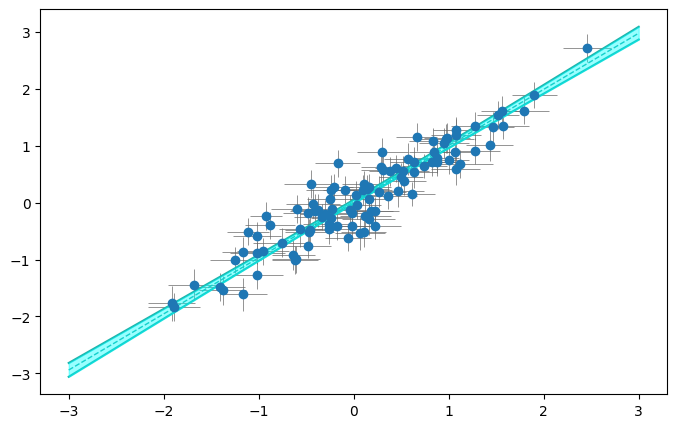

In [94]:
np.random.seed(42)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create fake data
N_data = 100
mean = [0, 0]
cov_mat = np.array([
        [1, 0.95],
        [0.95, 1]
    ])
err_scatter = 0.25

data = np.random.multivariate_normal(
    mean=mean,
    cov=cov_mat,
    size=N_data
)

x = data[:, 0]
y = data[:, 1]
xerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data))
yerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data))
ax.errorbar(x, y, yerr, xerr, fmt='o', elinewidth=0.5, ecolor='dimgrey')

# ODR fits
res, x_pred, y_pred, y_pred_lower, y_pred_upper = ODR_linear_fit(x, y, xerr, yerr, left_boundary=-3, right_boundary=3)
print(res.sd_beta)

ax.plot(x_pred, y_pred, c='lightseagreen', ls="--", lw=1.0, zorder=2)
ax.plot(x_pred, y_pred_upper, c='lightseagreen', ls="-", zorder=2)
ax.plot(x_pred, y_pred_lower, c='lightseagreen', ls="-", zorder=2)
ax.fill_between(x_pred, y1=y_pred_lower, y2=y_pred_upper, color='cyan', alpha=0.4, zorder=2)

# An answer from stackoverflow

/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3941/654856849.py:65: RuntimeWarning: invalid value encountered in log10
  pl1 = prediction_interval(log_func, [log10(xn), 1], xn, yn, max(out.eps), 68., out.beta, out.cov_beta)
/var/folders/50/_r7c0z0x3bl4zx6npn1b1x480000gn/T/ipykernel_3941/654856849.py:66: RuntimeWarning: invalid value encountered in log10
  pl2 = prediction_interval(log_func, [log10(xn), 1], xn, yn, max(out.eps), 95., out.beta, out.cov_beta)


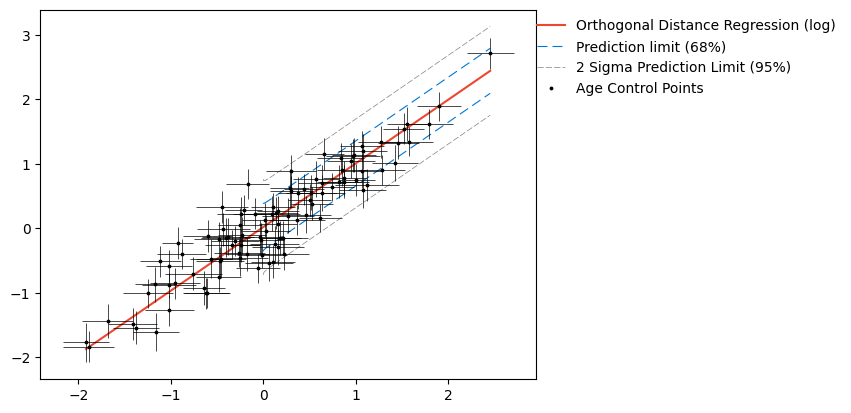

In [97]:
from scipy.stats import t
from scipy.odr import ODR, Model, RealData
from matplotlib.pyplot import subplots, savefig
from numpy import log10, array, linspace, zeros, sqrt

def prediction_interval(func, dfdp, x, y, yerr, signif, popt, pcov):
    """
    * Calculate Preduction Intervals
    *  adapted from Extraterrestrial Physics pdf
    *
    *  func    : function that we are using
    *  dfdp    : derivatives of that function (calculated using sympy.diff)
    *  x       : the x values (calculated using numpy.linspace)
    *  y       : the y values (calculated by passing the ODR parameters and x to func)
    *  y_err   : the maximum residual on the y axis
    *  signif  : the significance value (68., 95. and 99.7 for 1, 2 and 3 sigma respectively)
    *  popt    : the ODR parameters for the fit, calculated using scipy.odr.run()
    *  pcov    : the covariance matrix for the fit, calculated using scipy.odr.run()
    """
    # get number of fit parameters and data points
    np = len(popt)
    n = len(x)

    # convert provided value to a significance level (e.g. 95. -> 0.05), then calculate alpha
    alpha = 1. - (1 - signif / 100.0) / 2

    # student’s t test
    tval = t.ppf(alpha, n - np)

    # process covarianvce matrix and derivatives
    d = zeros(n)
    for j in range(np):
        for k in range(np):
            d += dfdp[j] * dfdp[k] * pcov[j,k]

    # return prediction band offset for a new measurement
    return tval * sqrt(yerr**2 + d)


def log_func(beta, x):
    """
    * Log function for fitting using ODR
    """
    return beta[0] * x + beta[1]


def plot_shed_curve(x_data, y_data, x_err, y_err):
    """
    * Fit curve using ODR and plot
    """
    # make function into Model instance (either log or linear)
    model = Model(log_func)

    # make data into RealData instance
    data = RealData(x_data, y_data, sx=x_err, sy=y_err)

    # initialise the ODR instance
    out = ODR(data, model, beta0=[-0.89225534, 59.09509794]).run()

    # fit model using ODR params
    xn = linspace(min(x_data), max(x_data), 1000)
    yn = log_func(out.beta, xn)

    # calculate curve and confidence bands
    pl1 = prediction_interval(log_func, [log10(xn), 1], xn, yn, max(out.eps), 68., out.beta, out.cov_beta)
    pl2 = prediction_interval(log_func, [log10(xn), 1], xn, yn, max(out.eps), 95., out.beta, out.cov_beta)

    # create a figure to draw on and add a subplot
    fig, ax = subplots(1)

    # plot y calculated from px against de-logged x (and 1 and 2 sigma prediction intervals)
    ax.plot(xn, yn, '#EC472F', label='Orthogonal Distance Regression (log)')
    ax.plot(xn, yn + pl1, '#0076D4', dashes=[9, 4.5], label=f'Prediction limit (68%)', linewidth=0.8)
    ax.plot(xn, yn - pl1, '#0076D4', dashes=[9, 4.5], linewidth=0.8)
    ax.plot(xn, yn + pl2, '0.5', dashes=[9, 3], label='2 Sigma Prediction Limit (95%)', linewidth=0.5)
    ax.plot(xn, yn - pl2, '0.5', dashes=[9, 3], linewidth=0.5)

    # plot points and error bars
    ax.plot(x_data, y_data, 'k.', label='Age Control Points', markersize=3.5)
    ax.errorbar(x_data, y_data, ecolor='k', xerr=x_err, yerr=y_err, fmt=" ", linewidth=0.5, capsize=0)

    # # labels, extents etc.
    # ax.set_ylim(0, 60)
    # ax.set_xlabel('Mean R-Value')
    # ax.set_ylabel('Age (ka)')
    # ax.set_title('Orthogonal Distance Regression and Prediction Limits')

    # configure legend
    ax.legend(bbox_to_anchor=(0.99, 0.99), borderaxespad=0., frameon=False)

    # export the figure
    savefig('pyrenees.png')

# plot the curve
plot_shed_curve(x, y, xerr, yerr)

# Compare with `hyperfit`

(array([ 1.02263414, -0.25092678]), 0.0003135572104956398, -67.87919595876483)


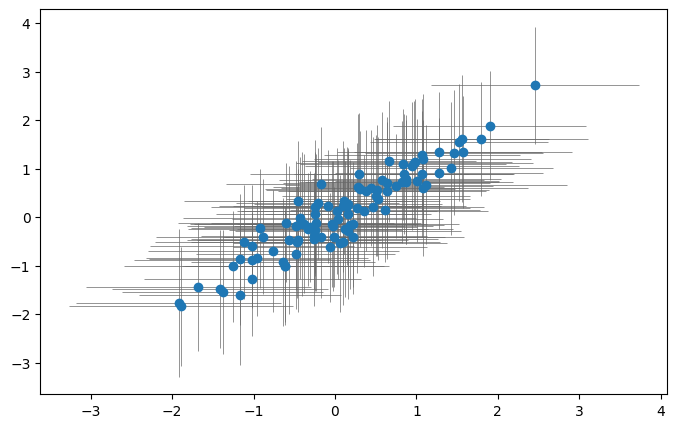

In [131]:
import numpy as np
from hyperfit.linfit import LinFit
from hyperfit.data import ExampleData

np.random.seed(42)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create fake data
N_data = 100
mean = [0, 0]
cov_mat = np.array([
        [1, 0.95],
        [0.95, 1]
    ])
err_scatter = 0.25

data = np.random.multivariate_normal(
    mean=mean,
    cov=cov_mat,
    size=N_data
)

x = data[:, 0]
y = data[:, 1]
xerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data)) * 5
yerr = np.absolute(np.random.normal(loc=err_scatter, scale=err_scatter/np.sqrt(N_data), size=N_data)) * 5
ax.errorbar(x, y, yerr, xerr, fmt='o', elinewidth=0.5, ecolor='dimgrey')

data, cov = np.empty((2, N_data)), np.empty((2, 2, N_data))
for i, (x, y, ex, ey, rho_xy) in enumerate(zip(x, y, xerr, yerr, np.zeros(N_data))):
    cov[:, :, i] = np.array([[ex ** 2, ex * ey * rho_xy], [ex * ey * rho_xy, ey ** 2]])
    data[:, i] = np.random.multivariate_normal([x, y], cov[:, :, i])

hf = LinFit(data, cov, weights=None)

bounds = ((-3.0, 3.0), (-3.0, 3.0), (1.0e-5, 5.0))
print(hf.optimize(bounds, verbose=False))

Std =  0.18594617605031874


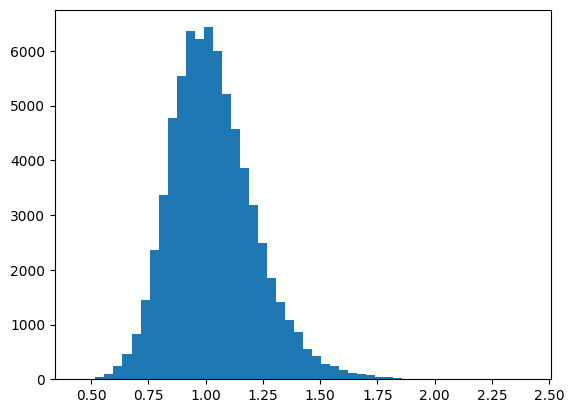

In [132]:
# Using emcee
mcmc_samples, mcmc_lnlike = hf.emcee(bounds, verbose=False)

a = mcmc_samples[0]

plt.hist(a, bins=50)
print("Std = ", np.std(a))

Hyperfit's error estimates scale with the uncertainties of the dataset.

Conclusion: use ODR's `cov_beta`.